In [1]:
import numpy as np
np.random_seed = 9843

import pandas as pd
pd.set_option('display.precision',10)
pd.set_option('display.max_colwidth',100)

import matplotlib 
matplotlib.use('Agg')
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from matplotlib import pyplot
rcParams['figure.figsize'] = 12, 4
get_ipython().magic(u'matplotlib inline')

from time import time
import scipy

# New York City Taxi Trip Duration
## Share code and data to improve ride time predictions
https://www.kaggle.com/c/nyc-taxi-trip-duration

* Richard Corrado richcorrado@gmail.com
* For the Fat Cat Fab Lab Machine Learning Meetup

From kaggle:

"In this competition, Kaggle is challenging you to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables."

Data:

File descriptions

    train.csv - the training set (contains 1458644 trip records)
    test.csv - the testing set (contains 625134 trip records)
    sample_submission.csv - a sample submission file in the correct format

Data fields

    id - a unique identifier for each trip
    vendor_id - a code indicating the provider associated with the trip record
    pickup_datetime - date and time when the meter was engaged
    dropoff_datetime - date and time when the meter was disengaged
    passenger_count - the number of passengers in the vehicle (driver entered value)
    pickup_longitude - the longitude where the meter was engaged
    pickup_latitude - the latitude where the meter was engaged
    dropoff_longitude - the longitude where the meter was disengaged
    dropoff_latitude - the latitude where the meter was disengaged
    store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
    trip_duration - duration of the trip in seconds
    
### Goal
Our goal in this notebook will be to develop an end-to-end framework for applying machine learning to the problem of predicting the target `trip_duration` from the other features.  We will discuss a minor amount of data exploration and feature engineering.  We will also discuss using the grid search method for optimizing hyperparameters using the training and validation error curves.

## Loading the data using pandas

Let's load the data using pandas:

In [2]:
train_orig_df = pd.read_csv("input/train.csv")
test_orig_df = pd.read_csv("input/test.csv")

Check the size of the dataset and number of features using shape (this method is included by numpy and pandas)

In [3]:
print(train_orig_df.shape)
print(test_orig_df.shape)

(1458644, 11)
(625134, 9)


For convenience, we'll save the size of the original kaggle training set:

In [4]:
num_train_orig = train_orig_df.shape[0]

We can look at the train and test dataframes:

In [5]:
train_orig_df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.9821548462,40.7679367065,-73.9646301270,40.7656021118,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.9804153442,40.7385635376,-73.9994812012,40.7311515808,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.9790267944,40.7639389038,-74.0053329468,40.7100868225,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.0100402832,40.7199707031,-74.0122680664,40.7067184448,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.9730529785,40.7932090759,-73.9729232788,40.7825202942,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.9828567505,40.7421951294,-73.9920806885,40.7491836548,N,443
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.9690170288,40.7578392029,-73.9574050903,40.7658958435,N,341
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.9692764282,40.7977790833,-73.9224700928,40.7605590820,N,1551
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.9994812012,40.7383995056,-73.9857864380,40.7328147888,N,255
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.9810485840,40.7443389893,-73.9729995728,40.7899894714,N,1225


In [6]:
test_orig_df.sample(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
75670,id0648239,1,2016-06-08 08:43:14,1,-73.9912719727,40.7300109863,-73.9822006226,40.7570266724,N
65223,id0649476,1,2016-06-11 02:10:05,2,-74.0037002563,40.7433967590,-74.0135726929,40.7079238892,N
197557,id1585328,2,2016-05-04 00:14:56,2,-73.9488906860,40.7817802429,-73.9550018311,40.7734107971,N
165251,id2515241,2,2016-05-12 23:09:46,1,-73.9888458252,40.7584533691,-73.9663162231,40.8007469177,N
139999,id2751181,2,2016-05-19 22:42:04,1,-73.9961013794,40.7344017029,-73.9803314209,40.7739486694,N


## Making a validation set

In order to validate our choice of model, we need to test the model on new data that was not part of the training set.  Since kaggle already uses the term "test set" to refer to the data that they use to test submissions, we'll use another common term of "validation set" to refer to the data that we set aside for our own testing.

For validation, we want to set aside 10% of the training data as a validation set:

In [7]:
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=1, test_size=0.10, random_state=59)

train_idx, valid_idx = list(ss.split(range(num_train_orig)))[0]

In [8]:
train_df = train_orig_df.iloc[train_idx]
valid_df = train_orig_df.iloc[valid_idx]

It's good to do a sanity check that all the dimensions were correct:

In [9]:
train_df.shape[0] + valid_df.shape[0] - num_train_orig

0

## Exploratory Data Analysis and New Features

We are going to do some exploratory data analysis and generate some new features.  It is convenient to combine training and test sets so that we can apply the same functions to both data sets at the same time.

**Caveats**: If we compute mean, standard deviation, etc, we want to compute them from the training set only.  In general, any information derived from the data should only come from the training data. However, must apply same functions to test as we did for training.   We don't want to learn anything from the test data, but the test data must be in exactly the same format as the training data.

In [10]:
num_train = train_df.shape[0] 

df = pd.concat([train_df, valid_df, test_orig_df])

In [11]:
df.shape

(2083778, 11)

We check for missing values:

In [12]:
df.isnull().sum()

dropoff_datetime      625134
dropoff_latitude           0
dropoff_longitude          0
id                         0
passenger_count            0
pickup_datetime            0
pickup_latitude            0
pickup_longitude           0
store_and_fwd_flag         0
trip_duration         625134
vendor_id                  0
dtype: int64

This dataset has no missing values, which is rare for real-world data. Next we check the data types of the features:

In [13]:
df.dtypes

dropoff_datetime       object
dropoff_latitude      float64
dropoff_longitude     float64
id                     object
passenger_count         int64
pickup_datetime        object
pickup_latitude       float64
pickup_longitude      float64
store_and_fwd_flag     object
trip_duration         float64
vendor_id               int64
dtype: object

### Dates

We note that the datetimes are stored as `object`s, which is pandas dtype for strings.  Sci-kit learn wants our data to be in numeric form, so we need to convert the date somehow.

It will be convenient to store the dates in epoch form, using 

In [14]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']).astype(np.int64) / 1e9
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime']).astype(np.int64) / 1e9

In [15]:
df[['pickup_datetime','dropoff_datetime']].sample(5)

,pickup_datetime,dropoff_datetime
155344,1463323624.0,-9.2233720369e+09
273519,1457879491.0,1.4578804290e+09
443426,1456349216.0,-9.2233720369e+09
277213,1460375772.0,-9.2233720369e+09
914893,1453040817.0,1.4530413070e+09


In [16]:
df[['pickup_datetime','dropoff_datetime']].dtypes

pickup_datetime     float64
dropoff_datetime    float64
dtype: object

**Note:** There is a lot of information in the date. In a more serious analysis, we should be computing new features based on whether the date is a weekday or a weekend,  the time of day, etc.

Furthermore, since we are trying to predict the trip duration, it is potentially problematic to include both the pickup and dropoff times in the features, since the trip duration is given by the difference of these.  The model we apply below doesn't do a good job of picking up this relationship, but this requires further study.

### Categorical Features

The feature `store_and_fwd_flag` was also an object:

In [17]:
df['store_and_fwd_flag'].value_counts()

N    2072303
Y      11475
Name: store_and_fwd_flag, dtype: int64

The simplest way to deal with this is to just convert to a binary using N=0 and Y=1:

In [18]:
df['store_and_fwd_flag'] = 1*(df['store_and_fwd_flag']=='Y')

Note, we've used the python behavior that:

In [19]:
print(1*True)
print(1*False)

1
0


The feature `vendor_id` is a categorical variable that's been stored as an integer:

In [20]:
df['vendor_id'].astype(str).value_counts()

2    1114676
1     969102
Name: vendor_id, dtype: int64

We'll also convert this to binary, since some ML techniques might otherwise assign significance to the different numerical values:

In [21]:
df['vendor_id'] = 1*(df['vendor_id'] == 1)

### New features: Ride distance

Next, we'll generate two new features based on the distance of the pickup and dropoff points.  We don't care what units these are in, so we'll just compute them from the latitudes and longitudes. We will use both the Euclidean, or L2 distance and the Taxicab, or L1 distance:

![Taxicab distance](Manhattan_distance.svg.png)

For this we can use a norm function from numpy:

In [22]:
def lp_dist(x, p=2):
    displacement = np.array(x[2] - x[0], x[3] - x[1])
    return np.linalg.norm(displacement, ord=p)

In [23]:
df[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].head(5)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
672790,-73.9540023804,40.7821731567,-73.9581909180,40.7688751221
1290607,-73.9618148804,40.7560882568,-73.9637985229,40.7711486816
371136,-73.9641265869,40.7613296509,-73.9609298706,40.7753753662
1132296,-73.9849243164,40.7742538452,-73.9775772095,40.7920379639
1194156,-74.0160140991,40.7153129578,-74.1773071289,40.6950073242


In [24]:
np.linalg.norm(df[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']], ord=2, axis=1)[:5]

array([ 119.43322527,  119.43340758,  119.43629432,  119.4695823 ,
        119.5594562 ])

In [25]:
df['l2_dist'] = np.linalg.norm(df[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']], 
                               ord=2, axis=1)
df['l1_dist'] = np.linalg.norm(df[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']], 
                               ord=1, axis=1)

In [26]:
df[['l2_dist', 'l1_dist']].head(5)

,l2_dist,l1_dist
672790,119.4332252685,229.4632415771
1290607,119.4334075841,229.4528503418
371136,119.4362943173,229.4617614746
1132296,119.4695822951,229.5287933350
1194156,119.5594561981,229.6036415100


### Skewed variables

Finally, we note that the `trip_duration` target is highly skewed:

In [27]:
print(df['trip_duration'].mean())
print(df['trip_duration'].std())

959.49227296
5237.4317245


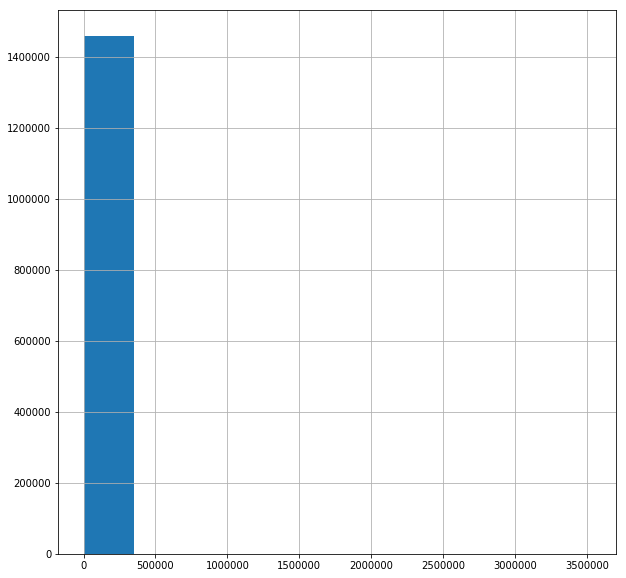

In [28]:
df['trip_duration'].hist(figsize=(10,10))

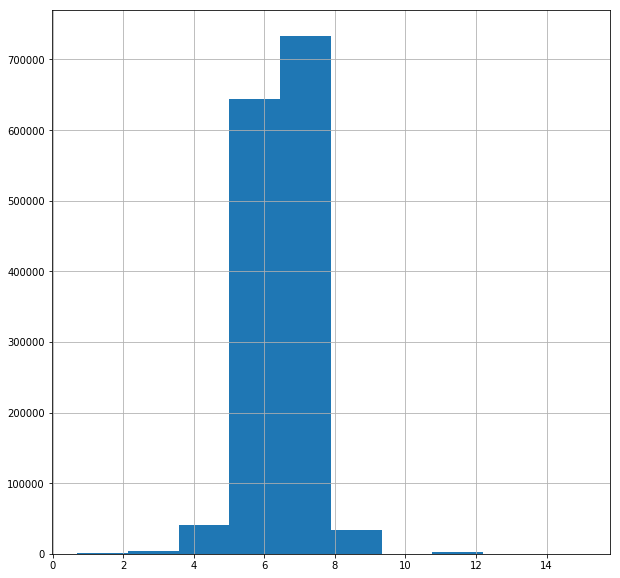

In [29]:
np.log(1+df['trip_duration']).hist(figsize=(10,10))

We see that the logarithm is much more normally distributed.  This is a common transformation to deskew data, and actually corresponds to the metric that kaggle is using to score this competition. 

In [30]:
df['trip_duration'] = np.log(1+df['trip_duration'])

Generally we will want to do much more data exploration and consider creating many more new features.  For now, since we have no missing data, we want to complete an end-to-end model and test predictions.

## From dataframe to numpy arrays

We will define training, validation and test sets:

In [31]:
df.iloc[train_idx].drop(['id','dropoff_datetime','trip_duration'], axis=1).head(5)

,dropoff_latitude,dropoff_longitude,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,store_and_fwd_flag,vendor_id,l2_dist,l1_dist
50940,40.7053718567,-74.0164566040,1,1459155941.0,40.7587814331,-73.9832382202,0,0,119.4577789332,229.4638481140
1331859,40.7383689880,-73.9874420166,1,1463077831.0,40.7382507324,-73.9875488281,0,0,119.4467192446,229.4516105652
980901,40.8035316467,-73.9648208618,2,1465996873.0,40.7737998962,-73.9515609741,0,0,119.4447949827,229.4937133789
1211372,40.7241744995,-74.0008239746,1,1461697200.0,40.7423019409,-73.9951019287,0,1,119.4562288643,229.4624023438
1381547,40.7653007507,-73.9542694092,1,1464204443.0,40.7669715881,-73.9789657593,0,1,119.4398470211,229.4655075073


In [32]:
df.loc[train_idx, 'trip_duration'].values

array([ 6.37672695,  6.33150185,  6.5366916 , ...,  5.57215403,
        5.05624581,  6.47234629])

In [33]:
df.iloc[num_train_orig:].head(5)

,dropoff_datetime,dropoff_latitude,dropoff_longitude,id,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,store_and_fwd_flag,trip_duration,vendor_id,l2_dist,l1_dist
0,-9.2233720369e+09,40.7566795349,-73.9901733398,id3004672,1,1467331198.0,40.7320289612,-73.9881286621,0,NaN,1,119.4528946647,229.4670104980
1,-9.2233720369e+09,40.6554031372,-73.9598083496,id3505355,1,1467331193.0,40.6799926758,-73.9642028809,0,NaN,1,119.3669978146,229.2594070435
2,-9.2233720369e+09,40.7295227051,-73.9861602783,id1217141,1,1467331187.0,40.7375831604,-73.9974365234,0,NaN,1,119.4488058806,229.4507026672
3,-9.2233720369e+09,40.7304687500,-73.9864273071,id2150126,1,1467331181.0,40.7719001770,-73.9560699463,0,NaN,0,119.4353826812,229.4448661804
4,-9.2233720369e+09,40.7558898926,-73.9615097046,id1598245,1,1467331173.0,40.7614746094,-73.9702148438,0,NaN,1,119.4338225758,229.4490890503


In [34]:
x_train = df.iloc[train_idx].drop(['id','dropoff_datetime','trip_duration'], axis=1).values
y_train = df.iloc[train_idx]['trip_duration'].values

x_valid = df.iloc[valid_idx].drop(['id','dropoff_datetime','trip_duration'], axis=1).values
y_valid = df.iloc[valid_idx]['trip_duration'].values

x_test = df.iloc[num_train_orig:].drop(['id','dropoff_datetime','trip_duration'], axis=1).values

In [35]:
print(x_train.shape)
print(y_train.shape)

print(x_valid.shape)
print(y_valid.shape)

print(x_test.shape)

(1312779, 10)
(1312779,)
(145865, 10)
(145865,)
(625134, 10)


## Preprocessing

Some machine learning techniques work best when all of the features vary over the same scale.  Therefore, we'll use the MaxAbsScaler, which will not change our binary features.

In [36]:
from sklearn.preprocessing import MaxAbsScaler

In [37]:
ma_scale = MaxAbsScaler()

ma_scale.fit(x_train)

MaxAbsScaler(copy=True)

In [38]:
ma_scale.transform(x_train)[:5]

array([[ 0.9267855 , -0.60702412,  0.11111111,  0.9944285 ,  0.7856193 ,
        -0.6067515 ,  0.        ,  0.        ,  0.66231254,  0.72012258],
       [ 0.92753678, -0.60678617,  0.11111111,  0.9971013 ,  0.78522358,
        -0.60678685,  0.        ,  0.        ,  0.66225122,  0.72008418],
       [ 0.92902041, -0.60660065,  0.22222222,  0.99909066,  0.78590878,
        -0.60649171,  0.        ,  0.        ,  0.66224056,  0.72021631],
       [ 0.9272136 , -0.60689591,  0.11111111,  0.99616039,  0.78530166,
        -0.6068488 ,  0.        ,  1.        ,  0.66230395,  0.72011805],
       [ 0.92814997, -0.60651411,  0.11111111,  0.9978691 ,  0.78577717,
        -0.60671646,  0.        ,  1.        ,  0.66221312,  0.72012779]])

## Model: Decision Trees, Random Forests

For a model, we will start off simple, using Decision Trees. Let's look at some fictious data:

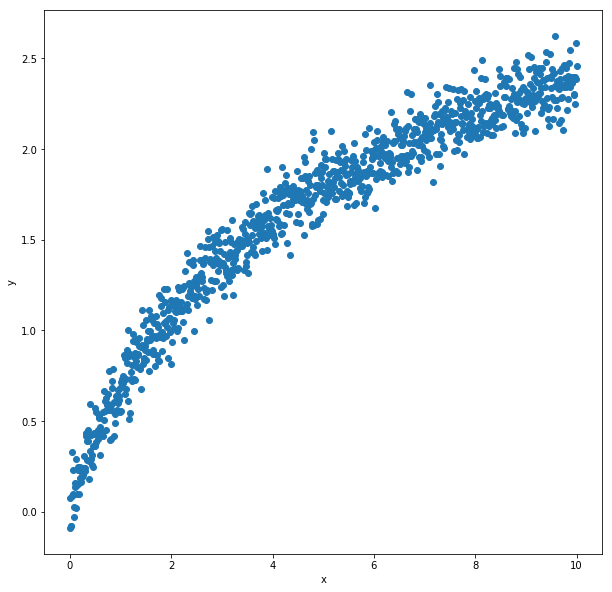

In [39]:
n_fake = 1000

plt.figure(figsize=(10,10))
X = np.linspace(0,10,n_fake)
Y = np.log(X+1) + np.random.normal(scale=0.1,size=n_fake)
plt.scatter(X, Y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

This data is clearly nonlinear, but a linear fit might be a reasonable first choice. This is easy in sci-kit learn:

In [40]:
from sklearn import linear_model
ls = linear_model.LinearRegression()
ls.fit(X.reshape(-1, 1), Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

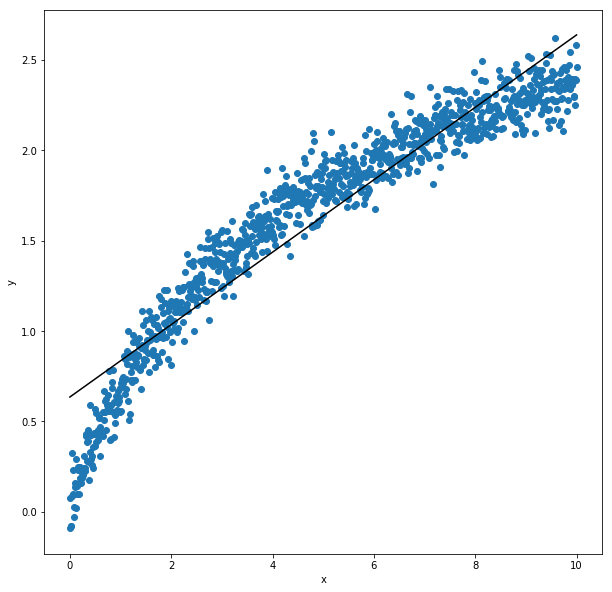

In [41]:
plt.figure(figsize=(10,10))
plt.scatter(X, Y)
plt.plot(X,ls.predict(X.reshape(-1, 1)), color='k')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

The mean-square error of this model is

In [42]:
from sklearn.metrics import mean_squared_error

In [43]:
mean_squared_error(Y, ls.predict(X.reshape(-1, 1)))

0.039345224860431613

 To ask how we can do better, let's consider an even more naive choice, where we choose the mean of the training data as the prediction for any data:

In [44]:
Y_mean = np.mean(Y) * np.ones(n_fake)
mean_squared_error(Y, Y_mean)

0.37465326755162148

The result is clearly worse, but suppose we use the means over different intervals to make the prediction.  This is the Decision Tree:

In [45]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=2)
dt.fit(X.reshape(-1, 1), Y)
mean_squared_error(Y, dt.predict(X.reshape(-1, 1)))

0.032803143990324982

This result is slightly better than the least squares error. It's a bit complicated technically to visualize the decision tree, but we can use graphviz:

In [46]:
from sklearn.tree import export_graphviz
export_graphviz(dt, out_file='decision_tree.dot')

After conversion to png format, we find the tree:

![decision-tree](decision_tree.png)

Graphically, the predictions are

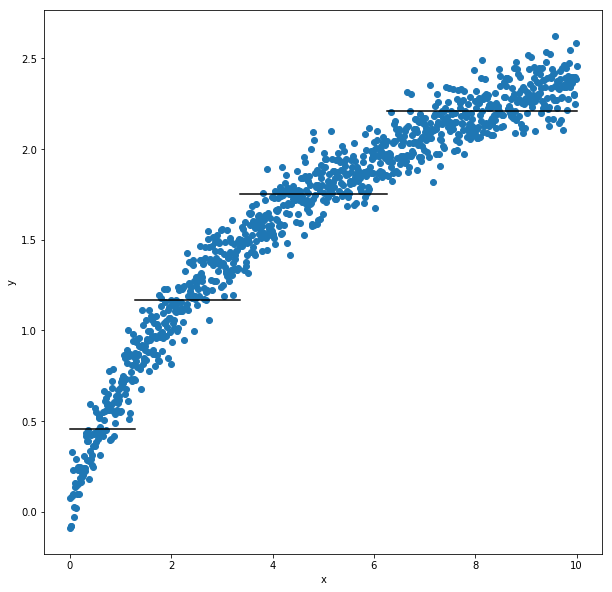

In [47]:
plt.figure(figsize=(10,10))
plt.scatter(X, Y)
n_grid = n_fake//4
plt.plot(np.linspace(0,1.2763, n_grid), 0.4537*np.ones(n_grid), color='k')
plt.plot(np.linspace(1.2763,3.3483, n_grid), 1.1701*np.ones(n_grid), color='k')
plt.plot(np.linspace(3.3483,6.2613, n_grid), 1.7532*np.ones(n_grid), color='k')
plt.plot(np.linspace(6.2613, 10, n_grid), 2.2112*np.ones(n_grid), color='k')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

If we have more features, there is more diversity to the possible splits we can have.  

In the Random Forests method,  we grow trees by only allowing splits at each node from a random sample of features. Therefore, each individual tree is at least slightly different than the other trees.  Finally we compute a prediction based on the average output of the family of trees.  Therefore Random Forests is an example of an ensemble model.  We use many different models (the individual trees) and use them to generate an aggregate result.

We will apply Random Forests to the trip duration problem:

In [48]:
from sklearn.ensemble import RandomForestRegressor

In [49]:
rf_regr = RandomForestRegressor(random_state=463, n_jobs=-1)

We will build a pipeline

In [50]:
from sklearn.pipeline import Pipeline

In [51]:
regr = Pipeline([
                ('scaler', MaxAbsScaler()), 
                ('regressor', RandomForestRegressor(random_state=463, n_jobs=-1))
                ])

In [52]:
regr.fit(x_train, y_train)

Pipeline(steps=[('scaler', MaxAbsScaler(copy=True)), ('regressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=463,
           verbose=0, warm_start=False))])

In [53]:
y_pred_train = regr.predict(x_train)

y_pred_valid = regr.predict(x_valid)

In [54]:
print(y_pred_train[:5])
print(y_train[:5])

[ 7.47332997  4.24484471  6.75689226  6.6871506   6.90718791]
[ 7.56371967  2.89037176  6.93828448  6.56526497  7.04925484]


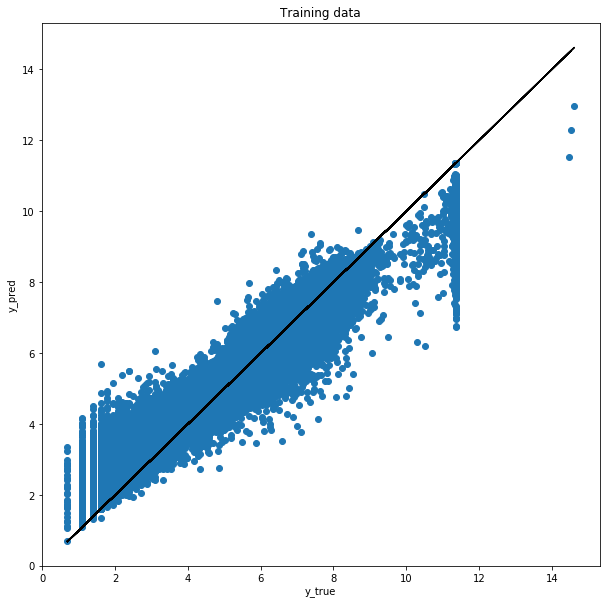

In [55]:
plt.figure(figsize=(10,10))
plt.scatter(y_train, y_pred_train)
plt.plot(y_train, y_train, color='k')
plt.xlabel("y_true")
plt.ylabel("y_pred")
plt.title("Training data")
plt.show()

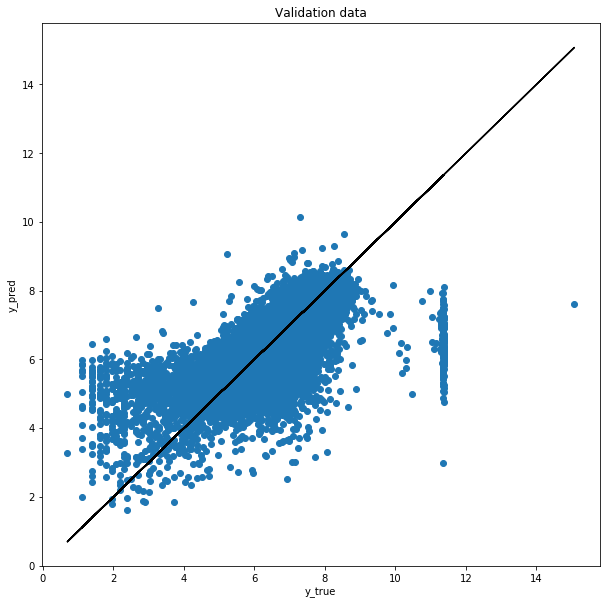

In [56]:
plt.figure(figsize=(10,10))
plt.scatter(y_valid, y_pred_valid)
plt.plot(y_valid, y_valid, color='k')
plt.xlabel("y_true")
plt.ylabel("y_pred")
plt.title("Validation data")
plt.show()

In [57]:
mean_squared_error(y_train, y_pred_train)

0.040084798843755994

In [58]:
mean_squared_error(y_valid, y_pred_valid)

0.2222497296703401

## Tuning Hyperparameters

We see that the validation error is much smaller than the training error, so we have overfitting.  The `RandomForestRegressor`, and thus the pipeline, has a number of parameters we can tune:

In [59]:
regr.get_params()

{'regressor': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=463,
            verbose=0, warm_start=False),
 'regressor__bootstrap': True,
 'regressor__criterion': 'mse',
 'regressor__max_depth': None,
 'regressor__max_features': 'auto',
 'regressor__max_leaf_nodes': None,
 'regressor__min_impurity_split': 1e-07,
 'regressor__min_samples_leaf': 1,
 'regressor__min_samples_split': 2,
 'regressor__min_weight_fraction_leaf': 0.0,
 'regressor__n_estimators': 10,
 'regressor__n_jobs': -1,
 'regressor__oob_score': False,
 'regressor__random_state': 463,
 'regressor__verbose': 0,
 'regressor__warm_start': False,
 'scaler': MaxAbsScaler(copy=True),
 'scaler__copy': True,
 'steps': [('scaler', MaxAbsScaler(copy=True)),
  ('regress

The most important are `max_depth`, `max_features` and `n_estimators`.  Let's generate error curves for these.

Sci-kit learn classes include the method `set_params()` to change the hyperparameters. So for instance, we can run

In [60]:
regr.set_params(regressor__n_estimators = 15)

Pipeline(steps=[('scaler', MaxAbsScaler(copy=True)), ('regressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=15, n_jobs=-1, oob_score=False, random_state=463,
           verbose=0, warm_start=False))])

Another very useful way to specify hypers is using python keyword arguments (kwargs):

In [61]:
regr.set_params(**{'regressor__n_estimators': 20})

Pipeline(steps=[('scaler', MaxAbsScaler(copy=True)), ('regressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=-1, oob_score=False, random_state=463,
           verbose=0, warm_start=False))])

This allows us to specify a list or distribution of hypers via a python dict:

In [62]:
mdepth_params = {'regressor__max_depth': range(5, 80, 10)}

This list can be thought of as a grid of points, where each point is a value of the hyperparameter that we want to test.  Deterimining the optimal value by computing the models errors at each grid point is known as the **grid search method** of optimizing hyperparameters.

We can unpack the dictionary with the `items()` method:

In [63]:
for k,v in mdepth_params.items():
    for val in v:
        print({k: val})

{'regressor__max_depth': 5}
{'regressor__max_depth': 15}
{'regressor__max_depth': 25}
{'regressor__max_depth': 35}
{'regressor__max_depth': 45}
{'regressor__max_depth': 55}
{'regressor__max_depth': 65}
{'regressor__max_depth': 75}


In [64]:
for k, v in mdepth_params.items():
    for count, val in enumerate(v):
        print(count)
        print((k,val))

0
('regressor__max_depth', 5)
1
('regressor__max_depth', 15)
2
('regressor__max_depth', 25)
3
('regressor__max_depth', 35)
4
('regressor__max_depth', 45)
5
('regressor__max_depth', 55)
6
('regressor__max_depth', 65)
7
('regressor__max_depth', 75)


It's convenient to build a function to unpack our dict, fit the model and then store the errors in a dataframe:

In [65]:
from tqdm import tqdm

def single_search(regr, params):
    regr_results_df = pd.DataFrame(dtype = 'float64')
    for k, v in params.items():
        for count, val in tqdm(enumerate(v)):
            regr.set_params(**{k: val})
            print("Setting parameter " + k + " to " + str(val))
            regr_results_df.loc[count, k] = val
            
            print("Fitting new model")
            regr.fit(x_train, y_train)
            
            print("Computing errors")
            regr_results_df.loc[count, 'train error'] = \
                mean_squared_error(y_train, regr.predict(x_train))
            regr_results_df.loc[count, 'validation error'] = \
                mean_squared_error(y_valid, regr.predict(x_valid))
    return regr_results_df

In [66]:
mdepth_results = single_search(regr, mdepth_params)

0it [00:00, ?it/s]

Setting parameter regressor__max_depth to 5
Fitting new model
Computing errors


1it [00:19, 19.99s/it]

Setting parameter regressor__max_depth to 15
Fitting new model
Computing errors


2it [01:10, 29.26s/it]

Setting parameter regressor__max_depth to 25
Fitting new model
Computing errors


3it [02:31, 44.54s/it]

Setting parameter regressor__max_depth to 35
Fitting new model
Computing errors


4it [04:11, 61.31s/it]

Setting parameter regressor__max_depth to 45
Fitting new model
Computing errors


5it [06:05, 77.19s/it]

Setting parameter regressor__max_depth to 55
Fitting new model
Computing errors


6it [08:03, 89.35s/it]

Setting parameter regressor__max_depth to 65
Fitting new model
Computing errors


7it [10:03, 98.45s/it]

Setting parameter regressor__max_depth to 75
Fitting new model
Computing errors


8it [12:00, 104.16s/it]


In [67]:
mdepth_results

,regressor__max_depth,train error,validation error
0,5.0,0.4699870552,0.4685267694
1,15.0,0.3767039853,0.3911326413
2,25.0,0.2331312380,0.2822375844
3,35.0,0.1222416576,0.2261227905
4,45.0,0.0594455177,0.2119039015
5,55.0,0.0383935802,0.2114770390
6,65.0,0.0340671140,0.2115755498
7,75.0,0.0335492394,0.2115400143


In [68]:
def plot_errors(dataframe):
    fig, ax = plt.subplots(figsize=(10,10))
    
    X = dataframe.iloc[:,0].values
    Y_train = dataframe.iloc[:,1].values
    Y_valid = dataframe.iloc[:,2].values
    
    ax.plot(X, Y_train, color='b', marker='v', label='training_error')
    ax.plot(X, Y_valid, color='g', marker='^', label='validation_error')
    
    ax.set_xlabel(dataframe.columns[0])
    ax.set_ylabel("Error")
    plt.legend()
    
    plt.show()

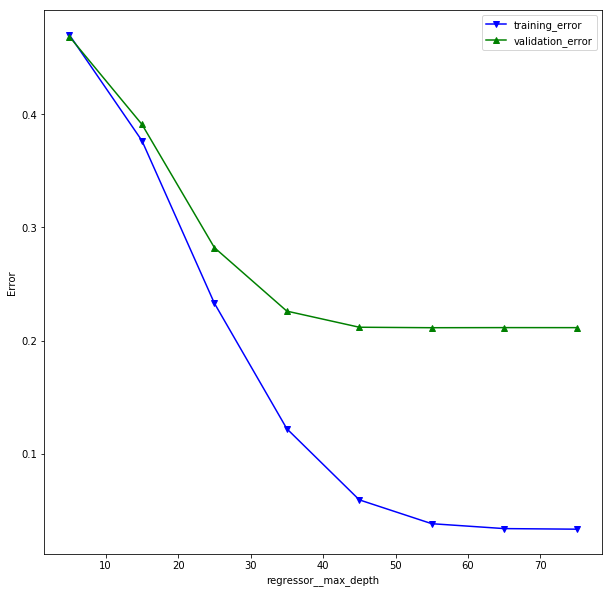

In [69]:
plot_errors(mdepth_results)

The validation error is minimized by a max depth of around 45:

In [70]:
regr.set_params(regressor__max_depth = 45)

Pipeline(steps=[('scaler', MaxAbsScaler(copy=True)), ('regressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=45,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=-1, oob_score=False, random_state=463,
           verbose=0, warm_start=False))])

Next, we'll see how changing the max features sampled at each node affects the errors:

In [71]:
n_feat = x_train.shape[1]

mfeat_params = {'regressor__max_features': range(1, n_feat + 1, 1)}

In [72]:
mfeat_results = single_search(regr, mfeat_params)

0it [00:00, ?it/s]

Setting parameter regressor__max_features to 1
Fitting new model
Computing errors


1it [00:27, 27.80s/it]

Setting parameter regressor__max_features to 2
Fitting new model
Computing errors


2it [01:05, 30.76s/it]

Setting parameter regressor__max_features to 3
Fitting new model
Computing errors


3it [01:54, 36.16s/it]

Setting parameter regressor__max_features to 4
Fitting new model
Computing errors


4it [02:51, 42.45s/it]

Setting parameter regressor__max_features to 5
Fitting new model
Computing errors


5it [03:59, 50.01s/it]

Setting parameter regressor__max_features to 6
Fitting new model
Computing errors


6it [05:15, 57.89s/it]

Setting parameter regressor__max_features to 7
Fitting new model
Computing errors


7it [06:41, 66.52s/it]

Setting parameter regressor__max_features to 8
Fitting new model
Computing errors


8it [08:18, 75.68s/it]

Setting parameter regressor__max_features to 9
Fitting new model
Computing errors


9it [10:03, 84.27s/it]

Setting parameter regressor__max_features to 10
Fitting new model
Computing errors


10it [11:56, 92.95s/it]


In [73]:
mfeat_results

,regressor__max_features,train error,validation error
0,1.0,0.0961110459,0.2533339224
1,2.0,0.0683175769,0.2241209615
2,3.0,0.0776309015,0.2197152797
3,4.0,0.0626961335,0.2144694355
4,5.0,0.0644787690,0.2132027695
5,6.0,0.0633349131,0.2121866816
6,7.0,0.0669351673,0.2122342251
7,8.0,0.0631875567,0.2115173313
8,9.0,0.0616075132,0.2124289301
9,10.0,0.0594455177,0.2119039015


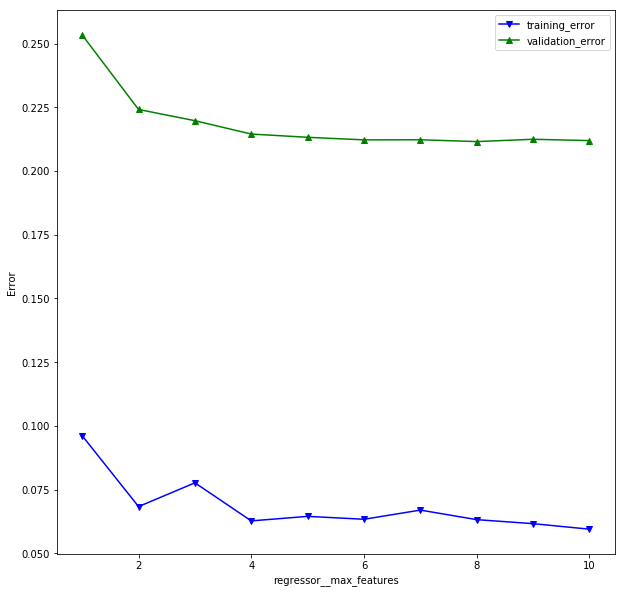

In [74]:
plot_errors(mfeat_results)

The validation error is optimized when around 8 features are sampled:

In [75]:
regr.set_params(regressor__max_features = 8)

Pipeline(steps=[('scaler', MaxAbsScaler(copy=True)), ('regressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=45,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
           oob_score=False, random_state=463, verbose=0, warm_start=False))])

In [76]:
nest_params = {'regressor__n_estimators': range(10, 135, 25)}

In [77]:
nest_results = single_search(regr, nest_params)

0it [00:00, ?it/s]

Setting parameter regressor__n_estimators to 10
Fitting new model
Computing errors


1it [00:51, 51.72s/it]

Setting parameter regressor__n_estimators to 35
Fitting new model
Computing errors


2it [03:25, 82.32s/it]

Setting parameter regressor__n_estimators to 60
Fitting new model
Computing errors


3it [07:52, 137.74s/it]

Setting parameter regressor__n_estimators to 85
Fitting new model
Computing errors


4it [14:04, 208.04s/it]

Setting parameter regressor__n_estimators to 110
Fitting new model
Computing errors


5it [22:00, 288.54s/it]


In [78]:
nest_results

,regressor__n_estimators,train error,validation error
0,10.0,0.0656747908,0.2201936120
1,35.0,0.0631977080,0.2085033224
2,60.0,0.0622693160,0.2064910099
3,85.0,0.0608585428,0.2053468679
4,110.0,0.0617683373,0.2051871202


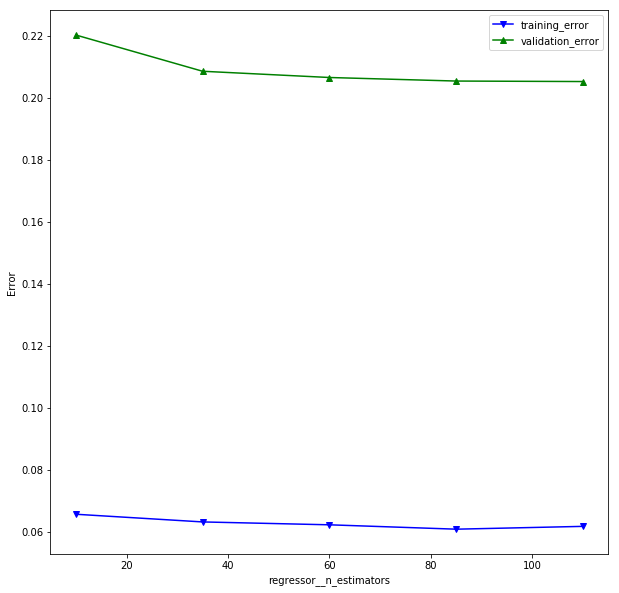

In [79]:
plot_errors(nest_results)

With Random Forest, increasing the number of estimators (trees in the ensemble) will always tend to decrease the training error. However, there are diminishing returns vs. the computation time.  We'll choose 85 trees:

In [80]:
regr.set_params(regressor__n_estimators = 85)

Pipeline(steps=[('scaler', MaxAbsScaler(copy=True)), ('regressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=45,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=85, n_jobs=-1,
           oob_score=False, random_state=463, verbose=0, warm_start=False))])

In [81]:
regr.fit(x_train, y_train)

y_pred_train_2 = regr.predict(x_train)

y_pred_valid_2 = regr.predict(x_valid)

print(y_pred_train_2[:5])
print(y_train[:5])

[ 7.46229682  4.9641058   6.84101738  6.58927209  6.74304235]
[ 7.56371967  2.89037176  6.93828448  6.56526497  7.04925484]


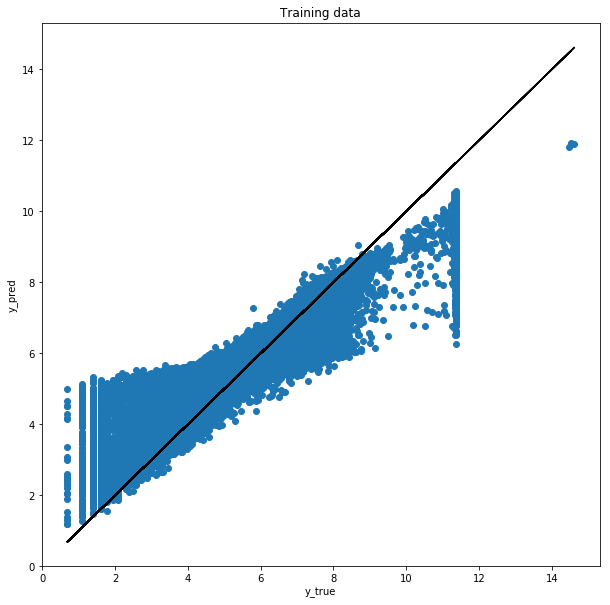

In [82]:
plt.figure(figsize=(10,10))
plt.scatter(y_train, y_pred_train_2)
plt.plot(y_train, y_train, color='k')
plt.xlabel("y_true")
plt.ylabel("y_pred")
plt.title("Training data")
plt.show()

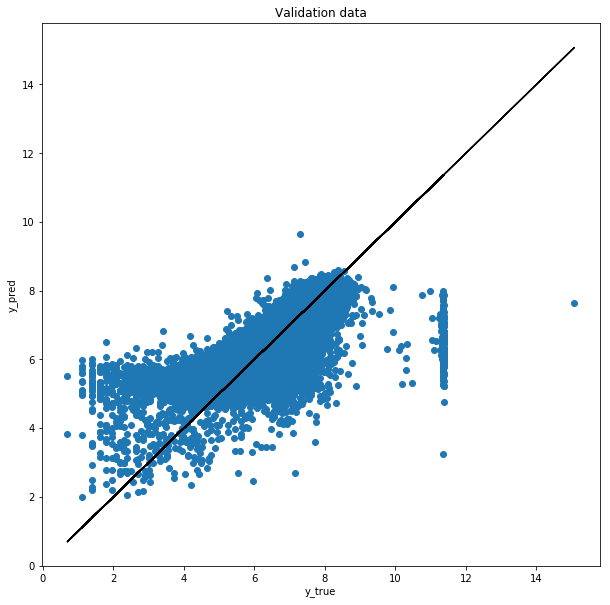

In [83]:
plt.figure(figsize=(10,10))
plt.scatter(y_valid, y_pred_valid_2)
plt.plot(y_valid, y_valid, color='k')
plt.xlabel("y_true")
plt.ylabel("y_pred")
plt.title("Validation data")
plt.show()

In [84]:
mean_squared_error(y_valid, regr.predict(x_valid))

0.2053468679097874

This error is around 10% smaller than that of the untuned Random Forest model.

## Summary

In this notebook, we saw how to use scikit-learn to develop an end-to-end model for predicting the trip duration for the Kaggle NYC Taxi dataset.  Our simple model involved converting string features to numerical ones, rescaling the features and applying a Random Forest model.  We also learned the grid search technique for optimizing hyperparameters.

By having a framework where we can obtain the model training and validation error, we can now go back and study the effect of engineering new features or applying different machine learning algorithms to the dataset.  We can relatively quickly determine whether a modification leads to a better model by comparing to the lowest error that we previously obtained.  During the modeling process, we will want to keep good records of the things that we've tried and the results obtained.  Code version control can be very helpful with that.